# Overview

This repository contains an implementation of sentiment analysis on reviews data using five different models. The goal of this project is to compare the performance of these models and identify the most effective approach for sentiment classification.

# Models

Model 1: Logistic Regression Model 2: Naive Bayes (NB) Model 3: Support Vector Machines (SVM) Model 4: Long Short-Term Memory (LSTM) Model 5: Convolutional Neural Network (CNN)

# Importing Libraries


In [1]:
import re
import string
import nltk
import numpy as np
import pandas as pd
# nltk.download()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.DataFrame(pd.read_excel("DATA.xlsx"))

df

In [3]:
# we can see that the dataset is balanced
df.columns


Index(['ID', 'URL', 'Date', 'Email', 'Phone', 'Name', 'Category',
       'Subcategory', 'Score', 'Feedback Text', 'IP', 'Location', 'OS',
       'Browser', 'Browser Language', 'Cookies', 'Display',
       'Business Partner  Country', 'Business Partner', 'Page Tag', 'Mois',
       'Entity'],
      dtype='object')

In [4]:
df.shape

(1732, 22)

In [5]:
#Dataset Information
print("############################################")
print("          Info Of the Data Set"              )
print("############################################")

df.info()

############################################
          Info Of the Data Set
############################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732 entries, 0 to 1731
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ID                         1732 non-null   int64         
 1   URL                        1732 non-null   object        
 2   Date                       1732 non-null   datetime64[ns]
 3   Email                      1409 non-null   object        
 4   Phone                      1291 non-null   object        
 5   Name                       1398 non-null   object        
 6   Category                   1732 non-null   object        
 7   Subcategory                1732 non-null   object        
 8   Score                      1732 non-null   int64         
 9   Feedback Text              1731 non-null   object        
 10  IP         

Data CLeaning and Preprocessing

In [6]:
# We first have to clean the text data

nltk.download('stopwords')
nltk.download('wordnet')

def clean_text(df, column_name="Feedback Text", languages=["english", "french", "spanish", "italian", "german"]):
    stop_words = set()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    for lang in languages:
        stop_words.update(set(nltk.corpus.stopwords.words(lang)))
    
    df[column_name] = df[column_name].str.lower()  # convert to lowercase
    df[column_name] = df[column_name].fillna('')  # replace NaN values with empty string
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'http\S+', '', x))  # remove URLs
    df[column_name] = df[column_name].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))  # remove punctuation
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'\d+', '', x))  # remove numbers
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))  # remove extra whitespaces
    df[column_name] = df[column_name].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    
    df[column_name] = df[column_name].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    
    return df


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
cleaned_df = clean_text(df, 'Feedback Text')

Word CLoud

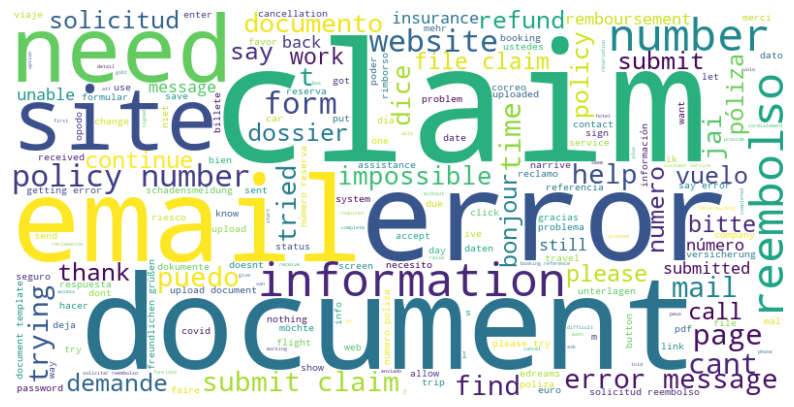

In [8]:
# Combine the text from all rows into a single string
text = ' '.join(cleaned_df['Feedback Text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Data Splitting

In [9]:
# Check the columns in your DataFrame to find the name of the target variable
print(cleaned_df.columns)

Index(['ID', 'URL', 'Date', 'Email', 'Phone', 'Name', 'Category',
       'Subcategory', 'Score', 'Feedback Text', 'IP', 'Location', 'OS',
       'Browser', 'Browser Language', 'Cookies', 'Display',
       'Business Partner  Country', 'Business Partner', 'Page Tag', 'Mois',
       'Entity'],
      dtype='object')


In [10]:
def map_scores(df, column_name="Score", threshold=4):
    # Map scores to 0 or 1 based on the specified threshold
    df[column_name] = df[column_name].apply(lambda x: 0 if x <= threshold else 1)
    return df

# Assuming your DataFrame is called cleaned_df
df = map_scores(df, threshold=4)

# Now, cleaned_df will have a new column "Score" with values 0 and 1 based on the threshold

In [11]:
df["Score"]

0       0
1       1
2       0
3       0
4       0
       ..
1727    0
1728    0
1729    0
1730    1
1731    0
Name: Score, Length: 1732, dtype: int64

In [12]:
unique_values = pd.unique(df["Score"])
print(len(unique_values))
print(unique_values)
df.Score.value_counts()

2
[0 1]


Score
0    1323
1     409
Name: count, dtype: int64

Data in unbalanced 

In [13]:
# Assuming your target variable is named differently, replace 'label' with the correct name
target_variable_name = 'Score'
x_train, x_test, y_train, y_test = train_test_split(cleaned_df['Feedback Text'], cleaned_df[target_variable_name], test_size=0.2, random_state=42)

In [14]:
# applt tf-idf to obtain embeddings
tf_idf = TfidfVectorizer()
x_train = tf_idf.fit_transform(x_train)
x_test = tf_idf.transform(x_test)

In [15]:
kfold = StratifiedKFold(n_splits=5, random_state = 42, shuffle = True)
scoring = {'Accuracy':'accuracy', 'Precision': 'precision', 'Recall':'recall', 'F1': 'f1_micro'}

Utility functions

In [16]:
def plot_roc_ml(clf,x_test,y_test,model_name):
    # Plot roc curve
    y_pred = clf.predict(x_test)
    y_pred_proba = clf.predict_proba(x_test)
    y_scores = pd.DataFrame(y_pred_proba, columns=clf.classes_.tolist())[1].values
    auc_value = roc_auc_score(y_test, y_scores)
    print("AUC score: ",auc_value)

    fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label=1.0)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', linewidth=2, label='ROC curve (area = %0.2f)' % auc_value)
    plt.plot([0, 1], [0, 1], color='navy', linewidth=2, linestyle='--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [17]:
def plot_roc_dl(y_test,y_pred_prob):
  # Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

  # Compute the area under the ROC curve (AUC)
  roc_auc = auc(fpr, tpr)

  # Plot the ROC curve
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], 'k--')  # Plot the random guessing curve
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.show()

In [18]:
def get_confusion_matrix_ml(clf,x_test,y_test):
    y_pred = clf.predict(x_test)

    # print classification metrics
    print(metrics.classification_report(y_test, y_pred, target_names=['Positive', 'Negative']))

    print("Confusion matrix:")
    cf_matrix = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%', cmap='Blues')

In [19]:
def get_confusion_matrix_dl(y_test,y_pred):
    # print classification metrics
    print(metrics.classification_report(y_test, y_pred, target_names=['Positive', 'Negative']))

    print("Confusion matrix:")
    cf_matrix = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%', cmap='Blues')

In [20]:
results = pd.DataFrame(columns=["Classifier", "Accuracy", "Precision", "Recall", "F1"])
accuracy, prec, rec, f1 = [], [], [], []

In [21]:
def fill_metrics_ml(clf):
    global accuracy, prec, rec, f1
    max_ind = np.nanargmax(clf_lr.cv_results_['mean_test_Accuracy'])
    accuracy.append(clf.cv_results_['mean_test_Accuracy'][max_ind])
    prec.append(clf.cv_results_['mean_test_Precision'][max_ind])
    rec.append(clf.cv_results_['mean_test_Recall'][max_ind])
    f1.append(clf.cv_results_['mean_test_F1'][max_ind])

In [22]:
def fill_metrics_dl(y_test,y_pred):
  
  global accuracy, prec, rec, f1
  # Calculate accuracy
  acc = accuracy_score(y_test, y_pred)

  # Calculate precision
  precision = precision_score(y_test, y_pred)

  # Calculate recall
  recall = recall_score(y_test, y_pred)

  # Calculate F1-score
  f1_sc = f1_score(y_test, y_pred)
  accuracy.append(acc)
  prec.append(precision)
  rec.append(recall)
  f1.append(f1_sc)

Logistic Regression

In [23]:
lr = LogisticRegression()
params = {
    "penalty": ("l1", "l2"),
    "tol": (0.1, 0.01, 0.001, 0.0001),
    "C": (10.0, 1.0, 0.1, 0.01)
}
clf_lr = GridSearchCV(lr, params, cv = kfold, scoring=scoring, refit='Accuracy')
clf_lr.fit(x_train, y_train)
print("Best score: ",clf_lr.best_score_)

Best score:  0.7667870036101083


In [24]:
fill_metrics_ml(clf_lr)

              precision    recall  f1-score   support

    Positive       0.76      1.00      0.87       264
    Negative       1.00      0.01      0.02        83

    accuracy                           0.76       347
   macro avg       0.88      0.51      0.44       347
weighted avg       0.82      0.76      0.66       347

Confusion matrix:


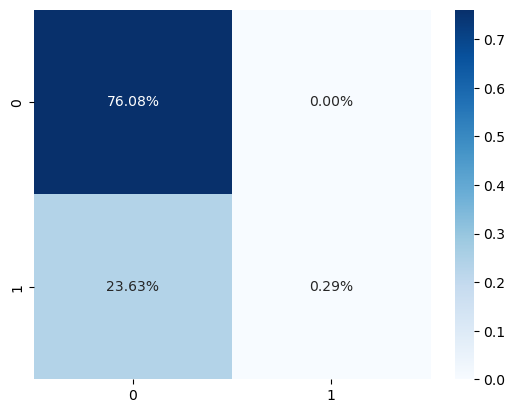

In [25]:
get_confusion_matrix_ml(clf_lr.best_estimator_,x_test,y_test)

AUC score:  0.6808141657539247


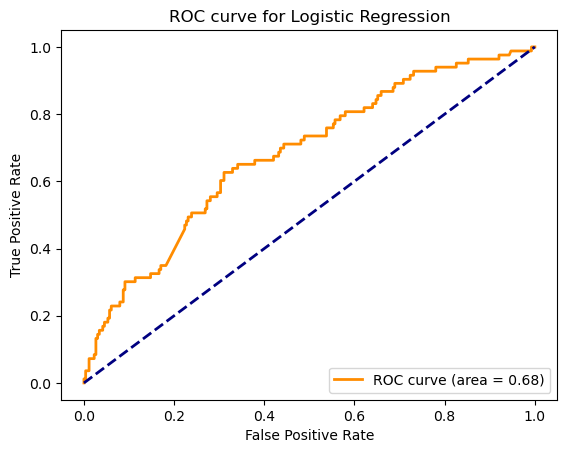

In [26]:
plot_roc_ml(clf_lr.best_estimator_,x_test,y_test,'Logistic Regression')

Naiver Bayes

In [27]:
nb = MultinomialNB()
params = {
    "alpha":[0.25, 0.5, 1, 1.25, 1.5, 2, 4, 8],
    "fit_prior":[True, False]
}
clf_nb = GridSearchCV(nb, params, cv = kfold, scoring=scoring, refit='Accuracy')
clf_nb.fit(x_train, y_train)
print("Best score: ",clf_nb.best_score_)

Best score:  0.7660649819494585


In [28]:
nb = MultinomialNB()
params = {
    "alpha":[0.25, 0.5, 1, 1.25, 1.5, 2, 4, 8],
    "fit_prior":[True, False]
}
clf_nb = GridSearchCV(nb, params, cv = kfold, scoring=scoring, refit='Accuracy')
clf_nb.fit(x_train, y_train)
print("Best score: ",clf_nb.best_score_)

Best score:  0.7660649819494585


In [29]:
fill_metrics_ml(clf_nb)

              precision    recall  f1-score   support

    Positive       0.76      1.00      0.87       264
    Negative       1.00      0.01      0.02        83

    accuracy                           0.76       347
   macro avg       0.88      0.51      0.44       347
weighted avg       0.82      0.76      0.66       347

Confusion matrix:


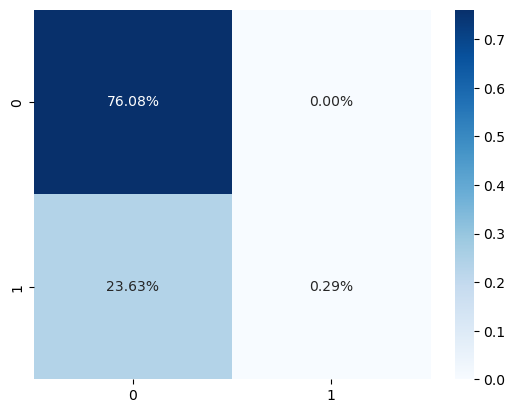

In [30]:
get_confusion_matrix_ml(clf_nb.best_estimator_,x_test,y_test)

AUC score:  0.7019441401971523


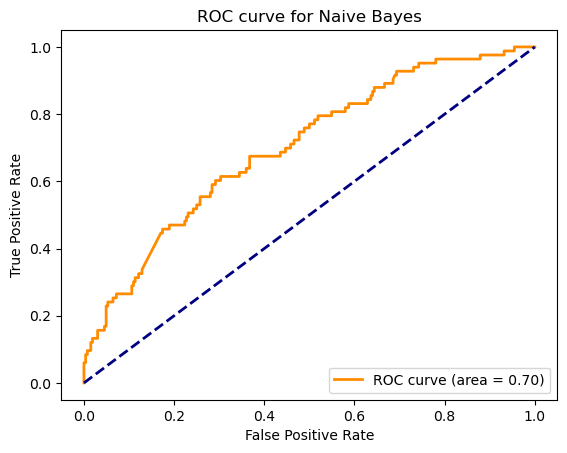

In [31]:
plot_roc_ml(clf_nb.best_estimator_,x_test,y_test,'Naive Bayes')

SVM

In [32]:
svm = SVC(probability=True)
params = {'kernel': ['rbf'], 
          'gamma': [ 0.001, 0.01, 0.1, 1],
          'C': [1, 10, 50, 100, 200, 300]}
clf_svm = GridSearchCV(svm, params, cv = kfold, scoring=scoring, refit='Accuracy')
clf_svm.fit(x_train, y_train)
print("Best score: ",clf_svm.best_score_)

Best score:  0.7754512635379063


In [33]:
fill_metrics_ml(clf_svm)

              precision    recall  f1-score   support

    Positive       0.77      0.99      0.87       264
    Negative       0.67      0.07      0.13        83

    accuracy                           0.77       347
   macro avg       0.72      0.53      0.50       347
weighted avg       0.75      0.77      0.69       347

Confusion matrix:


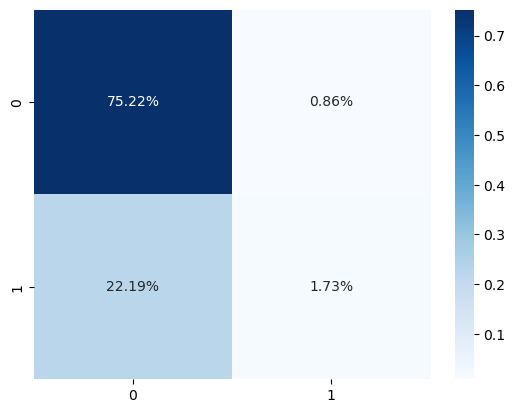

In [34]:
get_confusion_matrix_ml(clf_svm.best_estimator_,x_test,y_test)

AUC score:  0.6532949981745163


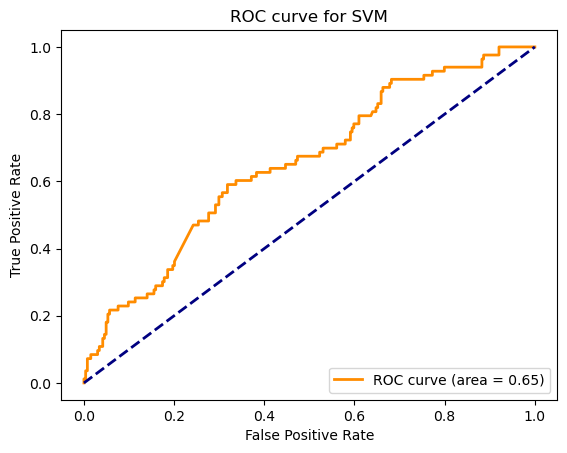

In [35]:
plot_roc_ml(clf_svm.best_estimator_,x_test,y_test,'SVM')

LSTM model

In [36]:
reviews = df['Feedback Text']
labels = df['Score']

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=42)

# Handle NaN values
x_test = x_test.fillna('')  # Replace NaN with empty string

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

# Convert text to sequences
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Pad sequences
max_len = 100  # Maximum sequence length
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len, padding='post')

# Define the LSTM model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(x_train_pad, y_train, epochs=50, batch_size=32, validation_data=(x_test_pad, y_test))

# Evaluate the model
loss, accuracy_lstm = model.evaluate(x_test_pad, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy_lstm)

# Generate predictions
y_pred_prob = model.predict(x_test_pad)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)



Epoch 1/50


44/44 [==============================] - 8s 101ms/step - loss: 0.5696 - accuracy: 0.7646 - val_loss: 0.5516 - val_accuracy: 0.7608
Epoch 2/50
44/44 [==============================] - 3s 67ms/step - loss: 0.5478 - accuracy: 0.7646 - val_loss: 0.5502 - val_accuracy: 0.7608
Epoch 3/50
44/44 [==============================] - 3s 73ms/step - loss: 0.5482 - accuracy: 0.7653 - val_loss: 0.5502 - val_accuracy: 0.7608
Epoch 4/50
44/44 [==============================] - 3s 77ms/step - loss: 0.5470 - accuracy: 0.7653 - val_loss: 0.5526 - val_accuracy: 0.7608
Epoch 5/50
44/44 [==============================] - 4s 91ms/step - loss: 0.5472 - accuracy: 0.7653 - val_loss: 0.5508 - val_accuracy: 0.7608
Epoch 6/50
44/44 [==============================] - 4s 91ms/step - loss: 0.5481 - accuracy: 0.7653 - val_loss: 0.5526 - val_accuracy: 0.7608
Epoch 7/50
44/44 [==============================] - 4s 83ms/step - loss: 0.5466 - accuracy: 0.7653 - val_loss: 0.5505 - val_accuracy: 0.7608
Epoch 8/

In [37]:
fill_metrics_dl(y_test, y_pred)

              precision    recall  f1-score   support

    Positive       0.76      1.00      0.86       264
    Negative       0.00      0.00      0.00        83

    accuracy                           0.76       347
   macro avg       0.38      0.50      0.43       347
weighted avg       0.58      0.76      0.66       347

Confusion matrix:


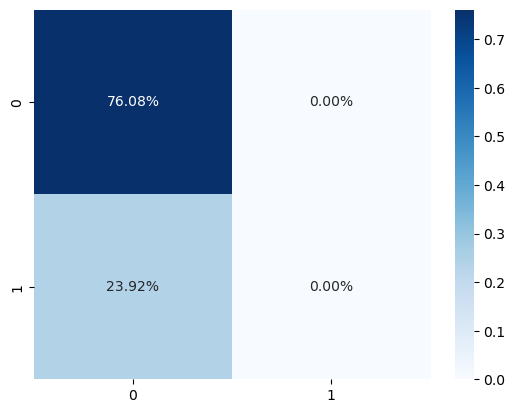

In [38]:
get_confusion_matrix_dl(y_test, y_pred)

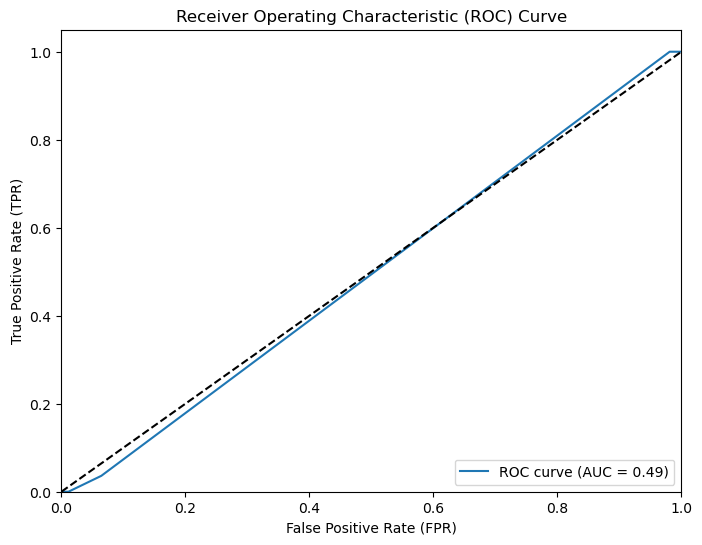

In [39]:
plot_roc_dl(y_test,y_pred_prob)

CNN

In [40]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length=max_len))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

# Compile the model`
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(x_train_pad, y_train, epochs=50, batch_size=32, validation_data=(x_test_pad, y_test))

loss, accuracy_cnn = model.evaluate(x_test_pad, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy_cnn)
# Generate predictions
y_pred_prob = model.predict(x_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

Epoch 1/50
44/44 [==============================] - 3s 47ms/step - loss: 0.5661 - accuracy: 0.7495 - val_loss: 0.5445 - val_accuracy: 0.7608
Epoch 2/50
44/44 [==============================] - 2s 47ms/step - loss: 0.5000 - accuracy: 0.7646 - val_loss: 0.5246 - val_accuracy: 0.7608
Epoch 3/50
44/44 [==============================] - 2s 54ms/step - loss: 0.3772 - accuracy: 0.8231 - val_loss: 0.5178 - val_accuracy: 0.7666
Epoch 4/50
44/44 [==============================] - 2s 45ms/step - loss: 0.1858 - accuracy: 0.9278 - val_loss: 0.6215 - val_accuracy: 0.7579
Epoch 5/50
44/44 [==============================] - 2s 45ms/step - loss: 0.0845 - accuracy: 0.9726 - val_loss: 0.7506 - val_accuracy: 0.7608
Epoch 6/50
44/44 [==============================] - 2s 41ms/step - loss: 0.0481 - accuracy: 0.9827 - val_loss: 0.8447 - val_accuracy: 0.7435
Epoch 7/50
44/44 [==============================] - 2s 47ms/step - loss: 0.0313 - accuracy: 0.9856 - val_loss: 0.9515 - val_accuracy: 0.7522
Epoch 8/50
44

In [41]:
fill_metrics_dl(y_test, y_pred)

              precision    recall  f1-score   support

    Positive       0.79      0.88      0.83       264
    Negative       0.39      0.25      0.31        83

    accuracy                           0.73       347
   macro avg       0.59      0.56      0.57       347
weighted avg       0.69      0.73      0.70       347

Confusion matrix:


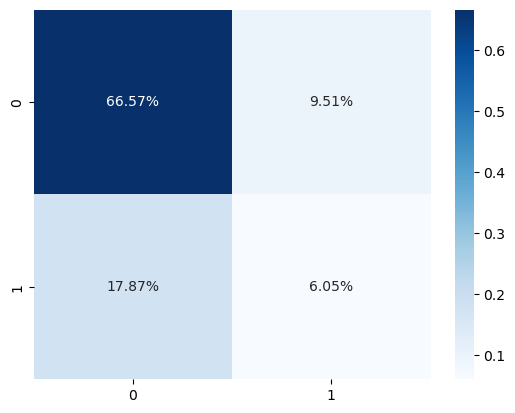

In [42]:
get_confusion_matrix_dl(y_test, y_pred)

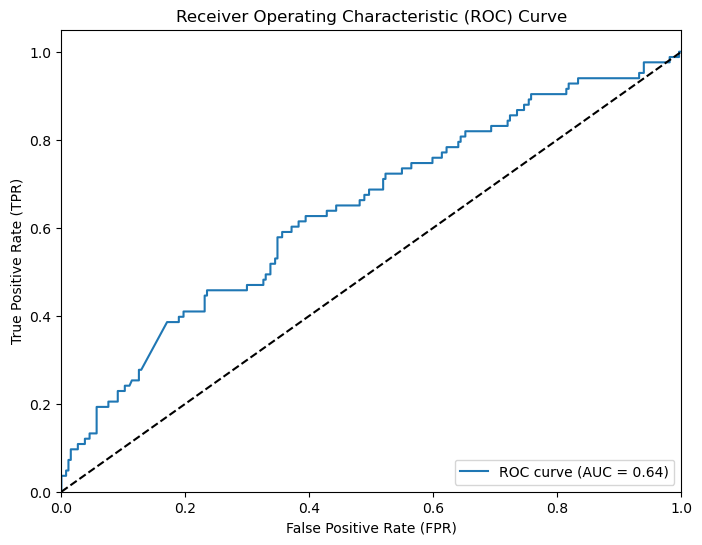

In [43]:
plot_roc_dl(y_test,y_pred_prob)

# Contingency table

In [44]:
results['Classifier'] = ['LR', 'NB', 'SVM', 'LSTM','CNN']
results['Accuracy'] = accuracy
results['Precision'] = prec
results['Recall'] = rec
results['F1'] = f1

In [45]:
results

,Classifier,Accuracy,Precision,Recall,F1
0,LR,0.766787,0.600000,0.009184,0.766787
1,NB,0.764621,0.000000,0.000000,0.764621
2,SVM,0.764621,0.000000,0.000000,0.764621
3,LSTM,0.760807,0.000000,0.000000,0.000000
4,CNN,0.726225,0.388889,0.253012,0.306569


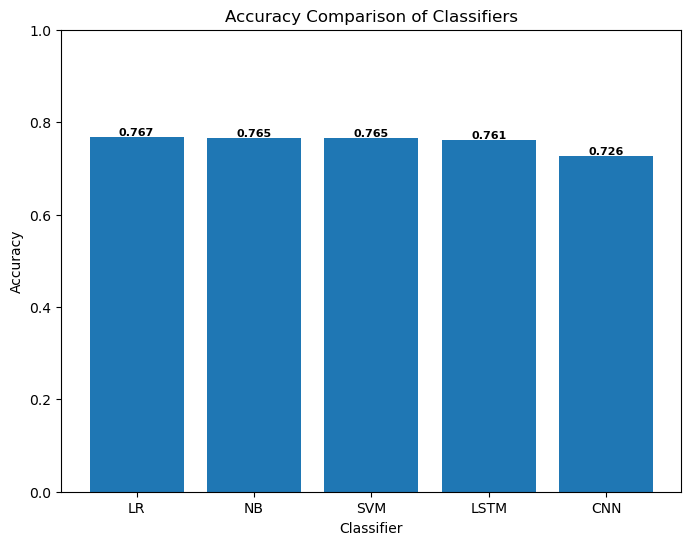

In [46]:
classifiers = results['Classifier']
accuracy_scores = results['Accuracy']

plt.figure(figsize=(8, 6))
bars = plt.bar(classifiers, accuracy_scores)
plt.title('Accuracy Comparison of Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.ylim([0, 1])


for bar, accuracy in zip(bars, accuracy_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), '%.3f' % accuracy,
             ha='center', va='bottom', fontsize=8, color='black', weight='bold')

plt.show()